In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from scipy import stats
import csv
import os
import sys
import logging
from keras.layers import LSTM
import dill
from keras.layers import Dropout


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Keras outputs warnings using `print` to stderr so let's direct that to devnull temporarily
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

import keras

# we're done
sys.stderr = stderr

# from keras.backend.tensorflow_backend import tf

# import absl.logging
# logging.root.removeHandler(absl.logging._absl_handler)
# absl.logging._warn_preinit_stderr = False

# logger = tf.get_logger()
# logger.setLevel(logging.FATAL)

# graph = tf.get_default_graph()


In [2]:
# !pip install keras
# !pip install tensorflow

In [3]:
dataset = read_csv('ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, index_col=3, parse_dates=True, squeeze=False)

/var/folders/_x/n_g0v4195t34h6v_rhvdzwww0000gq/T/ipykernel_60965/369673435.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  dataset = read_csv('ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, index_col=3, parse_dates=True, squeeze=False)


In [4]:
ex_R = dataset[dataset.lake=='R']
ex_R = ex_R.dropna(subset=["chl"])


In [5]:
#ex_R['chl'] = (ex_R['chl'] - ex_R['chl'].min()) / (ex_R['chl'].max() - ex_R['chl'].min()) *100

In [6]:
ex_R.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2008-05-15 to 2019-09-05
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lake                932 non-null    object 
 1   year                932 non-null    int64  
 2   doy                 932 non-null    int64  
 3   temp_sonde          932 non-null    float64
 4   ph                  928 non-null    float64
 5   do_sat              932 non-null    float64
 6   do_conc             932 non-null    float64
 7   bga_hylb            496 non-null    float64
 8   chl                 932 non-null    float64
 9   zmix_daily          909 non-null    float64
 10  temp_zmix_daily     909 non-null    float64
 11  zmix_hf             805 non-null    float64
 12  temp_zmix_hf        805 non-null    float64
 13  par                 929 non-null    float64
 14  temp_air            929 non-null    float64
 15  wind_spd            920 non-null    fl

In [7]:
years= sorted(list(set(ex_R['year'])))

In [8]:
train= ex_R.loc[ex_R['year'] < years[-1]]
test= ex_R[ex_R['year']==years[-1]]
print(len(ex_R),len(train),len(test))

932 816 116


### MLP model

In [9]:
# convert array into sequences of inputs and outputs
def to_supervised_mlp(data, n_input, n_out=7):
    # flatten data
    #data = data.reshape((data.shape[0]*data.shape[1]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [10]:
# build the model
def build_model_MLP(train, config):
    # prepare data
    n_input, n_nodes, n_epochs, n_batch = config
    train_x, train_y = to_supervised_mlp(train, n_input)
    # define parameters
    n_timesteps, n_outputs = train_x.shape[1], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [11]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [12]:
#final evaluation
def final_eval (train, test, config):
    train_array = np.array(train['chl'])
    test_array = np.array(test['chl'])
    #train_array= train_array.reshape(-1, 1)
    #test_array= test_array.reshape(-1, 1)
    model= build_model_MLP(train_array, config)
    test_x, test_y = to_supervised_mlp(test_array, config[0])
    predictions = model.predict(test_x)
    score, scores= evaluate_forecasts(test_y, predictions)
    return score, scores, predictions 

In [3]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [3, 5, 7]
    n_nodes = [128, 256]
    n_epochs = [20, 40]
    n_batch = [10, 50]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l]
                    configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [4]:
# model configs
cfig_list = model_configs()
#grid search
#mlp_scores = grid_search(train, cfig_list)


Total configs: 24


In [7]:
cfig_list

[[3, 128, 20, 10],
 [3, 128, 20, 50],
 [3, 128, 40, 10],
 [3, 128, 40, 50],
 [3, 256, 20, 10],
 [3, 256, 20, 50],
 [3, 256, 40, 10],
 [3, 256, 40, 50],
 [5, 128, 20, 10],
 [5, 128, 20, 50],
 [5, 128, 40, 10],
 [5, 128, 40, 50],
 [5, 256, 20, 10],
 [5, 256, 20, 50],
 [5, 256, 40, 10],
 [5, 256, 40, 50],
 [7, 128, 20, 10],
 [7, 128, 20, 50],
 [7, 128, 40, 10],
 [7, 128, 40, 50],
 [7, 256, 20, 10],
 [7, 256, 20, 50],
 [7, 256, 40, 10],
 [7, 256, 40, 50]]

In [20]:
rep= 50
mlp_test_scores= []
iter= 1
for config in cfig_list:
    print(iter)
    test_scores_config = []
    for _ in range (rep):
    # final evaluate configs
        test_scores_config.append(final_eval(train, test, config))
    mlp_test_scores.append (test_scores_config)
    iter+=1


1
Metal device set to: Apple M2
4/4 [==============================] - 0s 3ms/step
2
4/4 [==============================] - 0s 3ms/step
3
4/4 [==============================] - 0s 4ms/step
4
4/4 [==============================] - 0s 5ms/step
5
4/4 [==============================] - 0s 7ms/step
6
4/4 [==============================] - 0s 6ms/step
7
4/4 [==============================] - 0s 5ms/step
8
4/4 [==============================] - 0s 9ms/step
9
4/4 [==============================] - 0s 6ms/step
10
4/4 [==============================] - 0s 11ms/step
11
4/4 [==============================] - 0s 6ms/step
12
4/4 [==============================] - 0s 6ms/step
13
4/4 [==============================] - 0s 6ms/step
14
4/4 [==============================] - 0s 9ms/step
15
4/4 [==============================] - 0s 11ms/step
16
4/4 [==============================] - 0s 15ms/step
17
4/4 [==============================] - 0s 16ms/step
18
4/4 [==============================] - 0s 14ms/step
19

In [21]:
dill.dump(mlp_test_scores, open('mlp_test_scores_unnormalized.pkd', 'wb'))

In [23]:
all_scores = []
for i in range(len(mlp_test_scores)):
    config_scores = []
    for j in range (rep):
        overall = mlp_test_scores[i][j][0]
        scores = mlp_test_scores[i][j][1]
        config_scores.append([overall, scores])
    all_scores.append (config_scores)

In [24]:
overall_means = []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overall_means.append(np.mean(Overall_scores))
min_overall = np.min(overall_means)
min_overall_index= overall_means.index(min_overall)
print ("Min average over all days=", min_overall, "The config with Min average=", min_overall_index)

Min average over all days= 6.982634035051799 The config with Min average= 2


In [25]:
seven_means = []
for i in range (len(all_scores)):
    sevenl_scores= [all_scores[i][j][1][6] for j in range (rep)]
    seven_means.append(np.mean(sevenl_scores))
min_7 = np.min(seven_means)
min_7_index= seven_means.index(min_7)
print ("Min 7 days (averages over iterations) over all config=", min_7, "The config with Min 7 days (averages over iterations) =", min_7_index)

Min 7 days (averages over iterations) over all config= 9.242886847211848 The config with Min 7 days (averages over iterations) = 3


In [26]:
overalls= []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overalls.append (Overall_scores)

In [22]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


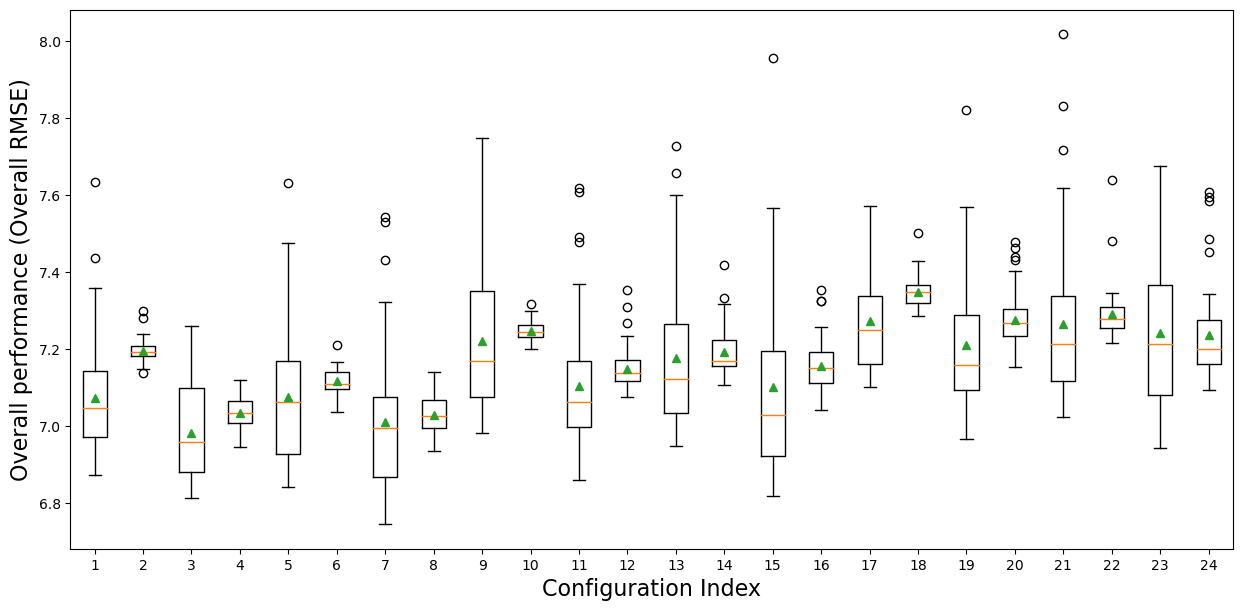

In [27]:
fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
ax= plt.axes()

ax.set_xlabel('Configuration Index', fontsize=16)
ax.set_ylabel('Overall performance (Overall RMSE)', fontsize=16)
ax.boxplot(overalls, showmeans = True)
# Creating plot

# show plot
plt.show()

In [28]:
### From previous run

In [188]:
mlp_result = pd.DataFrame ({'n_input' : [], 'n_nodes':[], 'n_epochs':[], 'n_batch':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], 'overall_score':[]} )
for i in range(len(mlp_scores)):
    df = {'n_input' : cfig_list[i][0], 'n_nodes':cfig_list[i][1], 'n_epochs':cfig_list[i][2], 'n_batch':cfig_list[i][3], '1':mlp_scores[i][1][0], '2':mlp_scores[i][1][1], '3':mlp_scores[i][1][2], '4':mlp_scores[i][1][3], '5':mlp_scores[i][1][4], '6':mlp_scores[i][1][5], '7':mlp_scores[i][1][6], 'overall_score':mlp_scores[i][0]}
    mlp_result = mlp_result.append(df, ignore_index = True)
dill.dump(mlp_result, open('mlp_result_pet.pkd', 'wb'))

In [189]:
#mlp_result= mlp_result.sort_values(by=['n_input','n_nodes', 'n_epochs', 'n_epochs'])
mlp_result.to_csv('mlp_result.csv', index=False)

In [190]:
#mlp_test = dill.load(open('mlp_test_pet.pkd', 'rb'))

In [191]:
cfig_list = model_configs()
mlp_test_scores= []
iter= 1
for config in cfig_list:
    print(iter)
# final evaluate configs
    mlp_test_scores.append(final_eval(train, test, config))
    iter+=1

Total configs: 64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [192]:
mlp_test = pd.DataFrame ({'n_input' : [], 'n_nodes':[], 'n_epochs':[], 'n_batch':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[], 'overall_score':[]} )
for i in range(len(mlp_test_scores)):
    df = {'n_input' : cfig_list[i][0], 'n_nodes':cfig_list[i][1], 'n_epochs':cfig_list[i][2], 'n_batch':cfig_list[i][3], '1':mlp_test_scores[i][1][0], '2':mlp_test_scores[i][1][1], '3':mlp_test_scores[i][1][2], '4':mlp_test_scores[i][1][3], '5':mlp_test_scores[i][1][4], '6':mlp_test_scores[i][1][5], '7':mlp_test_scores[i][1][6], 'overall_score':mlp_test_scores[i][0]}
    mlp_test = mlp_test.append(df, ignore_index = True)

mlp_test.to_csv('mlp_test_pet.csv', index=False)
    

In [193]:

dill.dump(mlp_test, open('mlp_test_pet.pkd', 'wb'))


### Test predictions for best cases

In [194]:
#mlp_result = dill.load(open('mlp_result_pet.pkd', 'rb'))

In [195]:
#mlp_test = dill.load(open('mlp_test_pet.pkd', 'rb'))

In [196]:
selected= pd.DataFrame()
selected= selected.append(mlp_test[mlp_test['overall_score']== mlp_test.overall_score.min()])
selected = selected.append(mlp_test[mlp_test['7']== mlp_test['7'].min()])
selected = selected.append(mlp_result[mlp_result['overall_score']== mlp_result['overall_score'].min()])
selected = selected.append(mlp_result[mlp_result['7']== mlp_result['7'].min()])

In [197]:
dill.dump(selected, open('selected_mlp_pet.pkd', 'wb'))
selected.to_csv('selected_mlp_pet.csv', index=False)


In [198]:
#selected = dill.load(open('selected_mlp_pet.pkd', 'rb'))

In [199]:
selected

,n_input,n_nodes,n_epochs,n_batch,1,2,3,4,5,6,7,overall_score
62,14.0,512.0,40.0,10.0,6.796852,9.766003,11.929056,14.343699,16.134912,17.162743,18.716538,14.115948
62,14.0,512.0,40.0,10.0,6.796852,9.766003,11.929056,14.343699,16.134912,17.162743,18.716538,14.115948
22,5.0,128.0,40.0,10.0,6.277996,8.428529,10.308552,11.884700,13.391985,14.151001,15.098643,11.744487
22,5.0,128.0,40.0,10.0,6.277996,8.428529,10.308552,11.884700,13.391985,14.151001,15.098643,11.744487


In [200]:
selected_configs = []
for index, row in selected.iterrows():
    config = [int(row['n_input']), int(row['n_nodes']), int(row['n_epochs']), int(row['n_batch'])]
    selected_configs.append(config)

In [201]:
#Best 7 Days, Best Overall Test, Best Validation, Best 7 Days Valid
final_predics= []
iter= 1
for config in selected_configs:
    print(iter)
# final evaluate configs
    final_predics.append(final_eval(train, test, config)[2])
    iter+=1

1
2
3
4


In [202]:
dill.dump(final_predics, open('mlp_final_predics_pet.pkd', 'wb'))

In [203]:
#final_predics = dill.load(open('mlp_final_predics_pet.pkd', 'rb'))

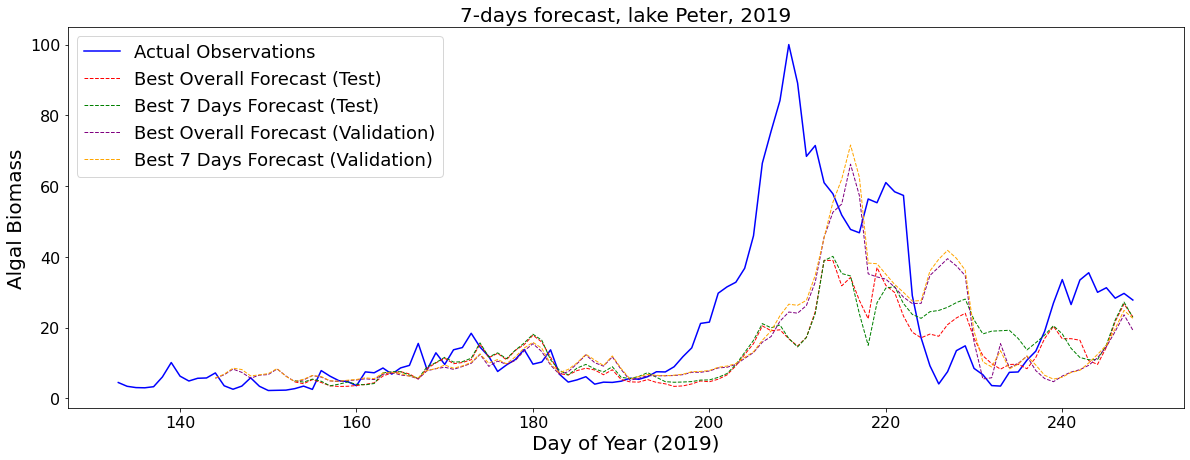

In [204]:
y= np.array(test['chl'])
x = test.doy
plt.figure(figsize=(20,7))
plt.plot(x, y, label="Actual Observations", color='Blue', linewidth=1.5)
plt.plot(x[selected_configs[0][0]+6:], final_predics[0][:,6], label="Best Overall Forecast (Test)", color='Red', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[1][0]+6:], final_predics[1][:,6], label="Best 7 Days Forecast (Test)", color='Green', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[2][0]+6:], final_predics[2][:,6], label="Best Overall Forecast (Validation)", color='purple', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[3][0]+6:], final_predics[3][:,6], label="Best 7 Days Forecast (Validation)", color='orange', linewidth=1 , linestyle='dashed')

#plt.plot(x[7:], y[:-7], label="Naive Forecast", color='Grey', linestyle='dashed',linewidth=1)
plt.title("7-days forecast, lake Peter, 2019", fontsize=20)
plt.xlabel('Day of Year (2019)',fontsize=20)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.ylabel('Algal Biomass',fontsize=20)
plt.legend(fontsize=18, loc=2)
#plt.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/comparison paper/Figures/7-days forecast, lake Peter, 2019_slides.jpeg')
plt.show()

In [222]:
config = [5, 128, 40, 10]
final_predict= final_eval(train, test, config)

In [228]:
n_input= config[0]
y= np.array(test['chl'])
x = test.doy
Predict_mlp= pd.DataFrame ({'doy':[], 'actual':[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]})
Predict_mlp['doy'] = test.doy
Predict_mlp['actual'] = test.chl
for i in range (6):
    Predict_mlp[i+1].iloc[n_input+i:-6+i] = np.array(final_predict[2])[:,i]
Predict_mlp[7].iloc[n_input+6:] = np.array(final_predict[2])[:,6]
Predict_mlp.to_csv('Predict_mlp.csv', index=False)

/Users/nn2tf/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
